In [36]:
import re

def get_label(line):
    fields = line.split('\t')
    notes = [note for note in fields 
             if 'note' in note or 'rest' in note] 
    notes_processed = []
    for note in notes:
        # ignore multi-rests and gracenotes
        if 'gracenote' in note:
            pass
        elif 'multirest' in note:
            pass
        else:
            # search for sharps and flats
            # redundant because we will try to recognize the clef key
            match = re.search(r'[A-Z][b#][0-9]', note)
            if match is not None:
                index = match.start()
                note = note[:index + 1] + note[index + 2:]
            notes_processed.append(note)
    return notes_processed

In [23]:
import os
import numpy as np
from PIL import Image
import shutil
from tqdm.notebook import tqdm

data_dir_path = 'D:\\primus'
labels = []

index=0
for folder_name in tqdm(os.listdir(data_dir_path)):
    with open(data_dir_path + "\\" + folder_name + f"\\{folder_name}.semantic") as semantic_file:
        content = semantic_file.readline()
        # only take samples in G2 clef
        # and contains 1 clef only
        if 'clef-G2' in content and content.count('clef') == 1:
            labels.append(get_label(content))
            shutil.copy(data_dir_path + "\\" + folder_name + f"\\{folder_name}.png",
                        f"d:\\primus_cleaned_data_with_rest\\{index}.png")
            index += 1

  0%|          | 0/87678 [00:00<?, ?it/s]

In [24]:
print(len(labels))

48040


In [25]:
print(labels[5])

['rest-quarter', 'rest-eighth', 'note-D4_sixteenth', 'note-E4_sixteenth', 'note-F4_eighth', 'note-D4_eighth', 'note-A4_eighth', 'note-D4_eighth', 'note-C4_quarter', 'rest-sixteenth', 'note-A4_sixteenth', 'note-G4_sixteenth', 'note-A4_sixteenth', 'note-F4_sixteenth', 'note-A4_sixteenth', 'note-D4_sixteenth', 'note-F4_sixteenth', 'note-B4_sixteenth', 'note-G4_sixteenth', 'note-F4_sixteenth', 'note-D4_sixteenth']


In [26]:
# save list of labels to json
import json

with open('dataset\\labels_with_rest.json', 'w') as f:
    json.dump(labels, f, indent=3)

In [27]:
# load list of labels from json
with open('dataset\\labels_with_rest.json', 'r') as f:
    labels_loaded = json.load(f)

In [21]:
print(len(labels_loaded))

48040


In [44]:
# Use the template matching method of OpenCV and Tesseract
# to identify notes and box them
import os
import cv2
import pytesseract
import numpy as np
import cv2 as cv
import imutils

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

def find_best_coeff(template, img2, res_max_global, increasing=True, decreasing=True, time=False):
    max_matches = 0
    best_coeff = 1
    template_copy = template

    ###################Decreasing:
    if decreasing:
        for i in range(6):
            template = template_copy
            img = img2.copy()
            # Scaling coeff in range [0.2, 1] with step = 0.1
            coeff = 1 - i/10.0
            template = cv2.resize(template, (0,0), fx=coeff, fy=coeff)
            w, h = template.shape[::-1]

            try:
                res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            except:
                continue
            res_max = res.max()

            threshold = res_max_global
            loc = np.where(res >= threshold)
            indices = set()
            for pt in zip(*loc[::-1]):
                x = int(pt[0] + w/2)
                upper_bound = x + 30
                lower_bound = x - 30
                found = False
                for i in range(lower_bound, upper_bound):
                    if i in indices: 
                        found = True
                        break
                if not found:
                    indices.add(x)
            if time:
                if res_max >= res_max_global:
                    res_max_global = res_max
                    best_coeff = coeff
            elif len(indices) > max_matches and res_max >= res_max_global:
                max_matches = len(indices)
                res_max_global = res_max
                best_coeff = coeff
                

    ###################Increasing:
    if increasing:
        for i in range(6):
            template = template_copy
            img = img2.copy()
            # Scaling coeff in range [1, 1.8] with step = 0.1
            coeff = 1 + i/10.0
            template = cv2.resize(template, (0,0), fx=coeff, fy=coeff)
            w, h = template.shape[::-1]
            if(template.shape[0] > img.shape[0]): break

            res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            res_max = res.max()

            threshold = res_max_global
            loc = np.where(res >= threshold)
            indices = set()
            for pt in zip(*loc[::-1]):
                x = int(pt[0] + w/2)
                upper_bound = x + 30
                lower_bound = x - 30
                found = False
                for i in range(lower_bound, upper_bound):
                    if(i in indices): 
                        found = True
                        break
                if not found:
                    indices.add(x)
            if time:
                if res_max >= res_max_global:
                    res_max_global = res_max
                    best_coeff = coeff
            elif len(indices) > max_matches and res_max >= res_max_global:
                max_matches = len(indices)
                res_max_global = res_max
                best_coeff = coeff

    return(res_max_global, best_coeff)

staff_line_space = 10
EXP_ALPHA = 0.5
def RLE(array:np.ndarray):
    run_length_encoding = np.zeros(shape=[1, array.shape[0]], dtype='float')
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j] < 200:
                run_length_encoding[0][i] += .01
    return run_length_encoding

def approximate_staff_line_space(array):
    global staff_line_space
    global EXP_ALPHA
    
    run_length_encoding = RLE(array)
    
    # Get max value of MLE list
    max_encoding = np.max(run_length_encoding)

    # Get potential indices for the staves
    # It is recognized by compare the RLE of each pixel to the the max_encoding value
    # (multiplied with a coeff to ensure that we get all the potential indices of the staves)
    img_indices = []
    for i in range(run_length_encoding.shape[1]):
        if run_length_encoding[0][i] >= max_encoding * .8:
            img_indices.append(i)

    # Then use it to get all the start and end indices of each staff
    staffs_index = []
    start_index = 0
    for i in range(1, len(img_indices) - 1):
        ####### predict staff line space size using exponential smoothing
        if i == (len(img_indices) - 2):
            staffs_index.append((img_indices[start_index], img_indices[len(img_indices) - 1]))
            break
        
        range_between = abs(img_indices[i] - img_indices[i + 1])
        
        # space size between staffs is usually bigger than
        # 3 * space sizes between staff lines
        if range_between > staff_line_space * 3: 
            staffs_index.append((img_indices[start_index], img_indices[i]))
            start_index = i + 1
        # if space between staff is not detected => only space between 2 staff lines
        # and internal space of ONE line is left.
        # space size between staff lines is usually bigger than 5 pixels
        elif range_between > 5:
            staff_line_space = int(EXP_ALPHA * staff_line_space + EXP_ALPHA * range_between)
    
def staff_to_boxed_notes(file):
    global staff_line_space
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.copyMakeBorder(img, 0, 0, staff_line_space * 2, staff_line_space * 2, 0, value=[255,255,255])
    approximate_staff_line_space(img)
    
    # img = cv.Sobel(img,cv.CV_16F,1,0,ksize=5)
    
    indices = set()
    
    drawn_indices = set()
    list_pt = {}
    boxes = []

    for dir in os.listdir('template\\roots_and_rests'):
        if 'rest' in dir: continue
        # The template to be matched
        template = cv2.imread(f'template\\roots_and_rests\\{dir}', cv2.IMREAD_GRAYSCALE)
        # template = cv.Sobel(template,cv.CV_16F,1,0,ksize=5)
        
        res_max, coeff = find_best_coeff(template, img, 0.7)
        template = cv2.resize(template,(0,0),fx=coeff,fy=coeff) #scale the tepmplate to the best coeff

        w, h = template.shape[::-1] # Get w and h of template

        try:
            res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) # Begin matching and get matches
        except:
            continue
        if '0' not in dir:
            threshold = res_max * 0.8
        else:
            threshold = res_max * 0.7
        loc = np.where(res >= threshold) # With threshold to offset the difference between template and notes (with staff)

        # Get a set of center indices of boxes for further testing
        
        for pt in zip(*loc[::-1]):
            x = int(pt[0] + w/2)
            upper_bound = x + 20
            lower_bound = x - 20
            found = False
            for i in range(lower_bound, upper_bound):
                if(i in indices):
                    found = True
                    break
            if not found:
                list_pt[x] = pt
                indices.add(x)
        for x in indices:
            pt = list_pt[x]
            # draw boxes in copy of image
            if x not in drawn_indices:
                box = img[0:img.shape[0], pt[0] - int(w / 2):pt[0] + int(w * 1.75)]
                box = imutils.resize(box, width=49, height=149)
                box = cv2.resize(box, (49, 149))
                boxes.append((x, box))
                # cv2.rectangle(img, (pt[0], 0), (pt[0] + int(w * 1.4), img.shape[0]), (255, 255,255), 2)
                drawn_indices.add(x)
        # cv2.imwrite('boxed.jpg', img)
    
    # sort found boxes by their x coordinates
    boxes.sort(key=lambda x:x[0])
    boxes = [i[1] for i in boxes]
    return boxes

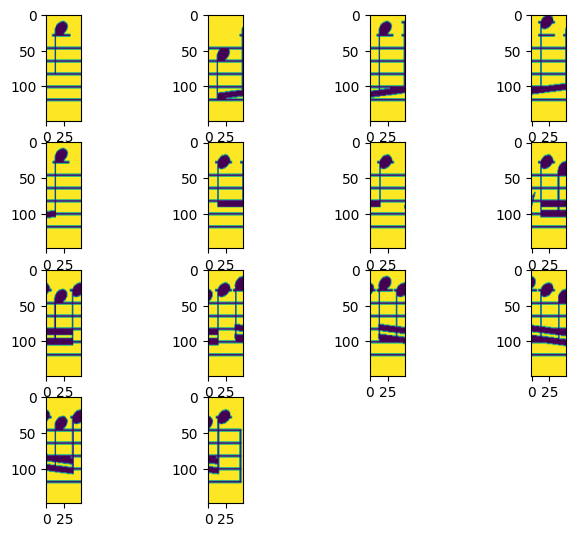

In [45]:
from matplotlib import pyplot as plt

file = "test_images\\primus_0.png"
notes_found = staff_to_boxed_notes(file)
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, len(notes_found) + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(notes_found[i - 1])
plt.show()

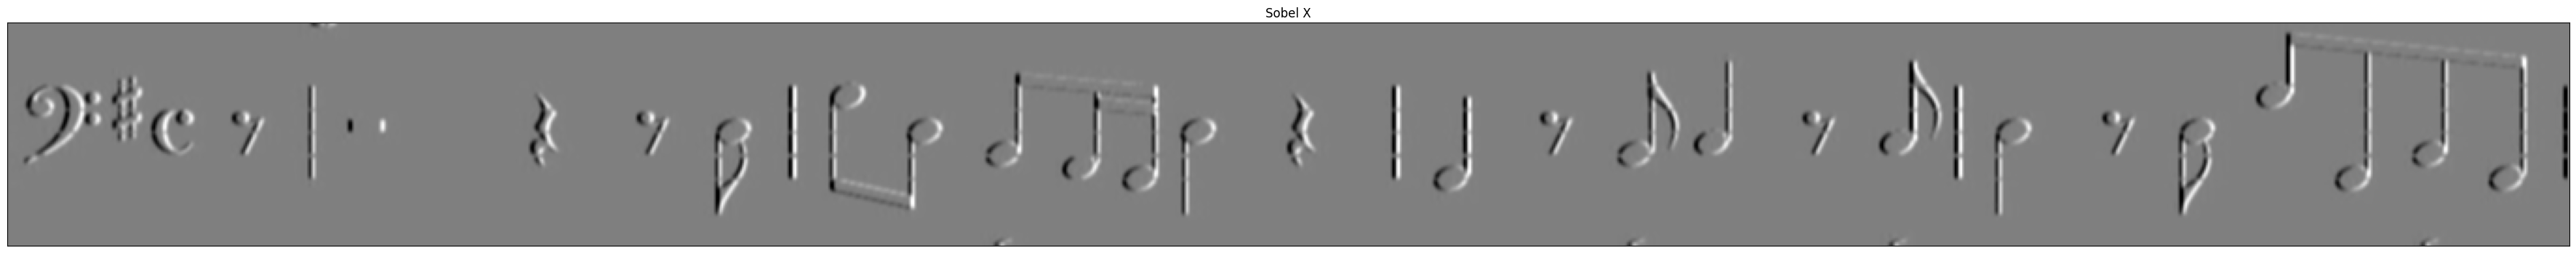

In [96]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
plt.figure(figsize=(100, 20))
 
img = cv.imread('staffs\\Albinoni - Sinfonia G-dur_staff_0.jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

sobelx = cv.Sobel(img,cv.CV_32F,1,0,ksize=5)
 
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.show()

[2, 15, 23, 27, 31, 90, 96, 102, 105, 114, 119, 124, 125, 127, 128, 131, 136, 142, 146, 181, 182, 183, 191, 195, 196, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 242, 243, 244, 245, 246, 252, 253, 254, 270, 277, 299, 300, 302, 312, 316, 318, 321, 331, 342, 344, 349, 374, 382, 388, 398, 405, 406, 407, 414, 415, 416, 419, 427, 429, 430, 432, 435, 436, 446, 448, 456, 487, 491, 526, 527, 528, 530, 592, 596, 599, 607, 629, 630, 632, 633, 634, 642, 646, 647, 648, 649, 650, 656, 657, 658, 674, 692, 702, 705, 712, 729, 754, 759, 765, 768, 784, 798, 808, 811, 818, 819, 820, 821, 823, 828, 852, 866, 892, 898, 903, 904, 905, 909, 916, 917, 921, 922, 924, 938, 940, 950, 957, 959, 967, 968, 998, 1002, 1006, 1010, 1024, 1029, 1032, 1035, 1038, 1064, 1067, 1068, 1069, 1072, 1081, 1084, 1098, 1100, 1110, 1116, 1130, 1163, 1167, 1169, 1170, 1173, 1176, 1190, 1191, 1192, 1196, 1203, 1211, 1218,

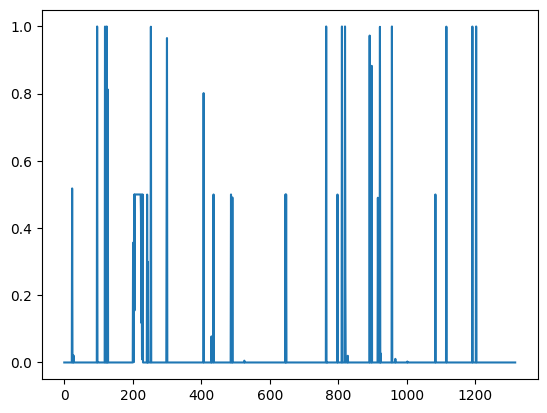

In [6]:
import tensorflow
import keras
import cv2 as cv
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

img = cv.imread('staffs\\Albinoni - Sinfonia G-dur_staff_0.jpg', cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (img.shape[1], 149))

model = keras.models.load_model('D:\\OMR_SIGMOID.keras')

filter_w = 49
filter_h = 149

index = 0

uncertainties = []
uncertain_indices = []
certain_indices = []

while index + filter_w < img.shape[1]:
    sub_img = img[0:filter_h, index:index + filter_w]
    predicted_values = model.predict(np.array([sub_img], dtype='float64'), verbose=0)
    predicted_values = predicted_values.reshape([25])
    
    uncertain_values = [i for i in predicted_values if (i < 1.0 and i > 0.0)]
    
    if len(uncertain_values) == 0:
        uncertainties.append(0)
        certain_indices.append(index)
    else:
        uncertainty = np.average(uncertain_values)
        uncertainties.append(uncertainty)
        uncertain_indices.append(index)
    index += 1

indices = np.arange(0, len(uncertainties))

plt.plot(indices, uncertainties)
print(uncertain_indices)

In [7]:
print(certain_indices)

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122, 123, 126, 129, 130, 132, 133, 134, 135, 137, 138, 139, 140, 141, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 197, 198, 199, 200, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 247, 248, 249, 250, 251, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 278, 279, 280, 281, 282, 283, 284, 285, 2

In [140]:
import json

test_index = 30
# load list of labelsfrom json
with open('dataset\\labels.json', 'r') as f:
    labels_loaded = json.load(f)
    
notes_count = sum(1 for token in labels_loaded[test_index] if 'note' in token and 'gracenote' not in token)
print(notes_count)
print(len(labels_loaded[test_index]))
print(labels_loaded[test_index])

16
17
['note-F5_half.', 'note-E5_eighth', 'note-D5_eighth', 'note-D5_half.', 'note-C5_eighth', 'note-B4_eighth', 'note-B4_half', 'note-B4_eighth', 'note-C5_eighth', 'note-C5_eighth', 'note-B4_eighth', 'note-A4_eighth', 'note-B4_eighth', 'gracenote-A4_eighth', 'note-G4_quarter', 'note-F4_quarter', 'rest-half']


In [46]:
import json
import joblib
import sys
from tqdm.notebook import tqdm

# load list of labelsfrom json
with open('dataset\\labels.json', 'r') as f:
    labels_loaded = json.load(f)
    
num = 10000
count = 0
correct_samples = []

def check_samples(i):
    file = f"d:\\primus_cleaned_data\\{i}.png"
    found_notes = list(staff_to_boxed_notes(file))
    notes_count = len(labels_loaded[i])
    print(f"checked {i}.png ", end='\r')
    if notes_count == len(found_notes):
        correct_samples.append(i)
        return 1
    else:
        return 0

for i in tqdm(range(num)):
    count += check_samples(i)
    print(f"correctly identified: {count}", end="\r")


  0%|          | 0/10000 [00:00<?, ?it/s]

In [47]:
# save list of correct samples' indices to json
import json

with open('dataset\\matched_samples.json', 'w') as f:
    json.dump(correct_samples, f, indent=3)

In [48]:
import json
from tqdm.notebook import tqdm

test_index = 30
# load list of labelsfrom json
with open('dataset\\matched_samples.json', 'r') as f:
    matched_samples = json.load(f)

count = 0
for i in tqdm(matched_samples[:10000]):
    boxes = staff_to_boxed_notes(f'D:\\primus_cleaned_data\\{i}.png')
    
    for box in boxes:
        cv2.imwrite(f"D:\\primus_notes_index\\{count}.jpg", box)
        count += 1

  0%|          | 0/7776 [00:00<?, ?it/s]